# Predicting Mortgage Delinquency Risk

Luopeiwen Yi

**Note: this is a new exercise, so if you find something weird, please bring it to my attention.**

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.

In [1]:
import pandas as pd
import numpy as np
import patsy
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

# Create a results dictionary
results = {}

## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/html/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex4_num_mortgages",
    "ex5_num_obs",
    "ex7_num_mortgages",
    "ex7_share_delinquent",
    "ex10_num_obs",
    "ex12_roc_auc",
    "ex14_false_omission_rate",
    "ex16_num_obs",
    "ex16_share_delinquent",
    "ex17_false_omission_rate",
}
```


### Submission Limits

Please remember that you are **only allowed FOUR submissions to the autograder.** Your last submission (if you submit 4 or fewer times), or your third submission (if you submit more than 4 times) will determine your grade Submissions that error out will **not** count against this total.

That's one more than usual in case there are issues with exercise clarity.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only difference between this data and the original Freddie Mac sampled data is that I've limited the scope of service data to three calendar years.

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004.txt`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004orig_3years.txt`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006.

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Load the data AND ensure your data has column names. You will likely need to reference the documentation to figure out how to do so.

In [2]:
orig = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2004/sample_orig_2004.txt",
    header=None,
    delimiter="|",
    encoding="latin1",
)
mortgage_info_records = [
    "CREDIT SCORE",
    "FIRST PAYMENT DATE",
    "FIRST TIME HOMEBUYER FLAG",
    "MATURITY DATE",
    "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION",
    "MORTGAGE INSURANCE PERCENTAGE (MI %)",
    "NUMBER OF UNITS",
    "OCCUPANCY STATUS",
    "ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)",
    "ORIGINAL DEBT-TO-INCOME (DTI) RATIO",
    "ORIGINAL UPB",
    "ORIGINAL LOAN-TO-VALUE (LTV)",
    "ORIGINAL INTEREST RATE",
    "CHANNEL",
    "PREPAYMENT PENALTY MORTGAGE (PPM) FLAG",
    "AMORTIZATION TYPE",
    "PROPERTY STATE",
    "PROPERTY TYPE",
    "POSTAL CODE",
    "LOAN SEQUENCE NUMBER",
    "LOAN PURPOSE",
    "ORIGINAL LOAN TERM",
    "NUMBER OF BORROWERS",
    "SELLER NAME",
    "SERVICER NAME",
    "SUPER CONFORMING FLAG",
    "PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER",
    "PROGRAM INDICATOR",
    "RELIEF REFINANCE INDICATOR",
    "PROPERTY VALUATION METHOD",
    "INTEREST ONLY INDICATOR (I/O INDICATOR)",
    "MI CANCELLATION INDICATOR",
]


orig.columns = mortgage_info_records
orig.head()

,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT-TO-INCOME (DTI) RATIO,...,NUMBER OF BORROWERS,SELLER NAME,SERVICER NAME,SUPER CONFORMING FLAG,PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER,PROGRAM INDICATOR,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR
0,701,200403,N,203402,45060.0,25,1,P,90,43,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
1,648,200403,N,202402,NaN,0,1,P,80,46,...,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
2,653,200403,Y,203402,20740.0,17,1,P,87,25,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
3,747,200403,N,203402,30700.0,0,2,I,70,34,...,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
4,731,200403,N,201902,NaN,0,1,P,80,40,...,2,"PROVIDENT FUNDING ASSOCIATES, L.P.","PROVIDENT FUNDING ASSOCIATES, L.P.",NaN,NaN,9,NaN,9,N,9


In [3]:
svcg = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2004/sample_svcg_2004orig_3years.txt",
    header=None,
    delimiter="|",
    encoding="latin1",
).iloc[
    :, 1:
]  # get rid of the first order column

monthly_mortgage_records = [
    "LOAN SEQUENCE NUMBER",
    "MONTHLY REPORTING PERIOD",
    "CURRENT ACTUAL UPB",
    "CURRENT LOAN DELINQUENCY STATUS",
    "LOAN AGE",
    "REMAINING MONTHS TO LEGAL MATURITY",
    "DEFECT SETTLEMENT DATE",
    "MODIFICATION FLAG",
    "ZERO BALANCE CODE",
    "ZERO BALANCE EFFECTIVE DATE",
    "CURRENT INTEREST RATE",
    "CURRENT NON-INTEREST BEARING UPB",
    "DUE DATE OF LAST PAID INSTALLMENT (DDLPI)",
    "MI RECOVERIES",
    "NET SALES PROCEEDS",
    "NON MI RECOVERIES",
    "TOTAL EXPENSES",
    "LEGAL COSTS",
    "MAINTENANCE AND PRESERVATION COSTS",
    "TAXES AND INSURANCE",
    "MISCELLANEOUS EXPENSES",
    "ACTUAL LOSS CALCULATION",
    "CUMULATIVE MODIFICATION COST",
    "STEP MODIFICATION FLAG",
    "PAYMENT DEFERRAL",
    "ESTIMATED LOAN TO VALUE (ELTV)",
    "ZERO BALANCE REMOVAL UPB",
    "DELINQUENT ACCRUED INTEREST",
    "DELINQUENCY DUE TO DISASTER",
    "BORROWER ASSISTANCE STATUS CODE",
    "CURRENT MONTH MODIFICATION COST",
    "INTEREST BEARING UPB",
]

svcg.columns = monthly_mortgage_records
svcg.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,DEFECT SETTLEMENT DATE,MODIFICATION FLAG,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,...,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,PAYMENT DEFERRAL,ESTIMATED LOAN TO VALUE (ELTV),ZERO BALANCE REMOVAL UPB,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB
0,F04Q10000027,200402,101000.0,0,0,360,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
1,F04Q10000027,200403,101000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
2,F04Q10000027,200404,101000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
3,F04Q10000027,200405,101000.0,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
4,F04Q10000027,200406,100000.0,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0


### Exercise 2

What is the unit of observation in `sample_orig_2004.txt` and in `sample_svcg_2004orig_3years.txt`?

> The unit of observation in the `sample_orig_2004.txt` dataset is an individual mortgage loan. The unit of observation in the `sample_svcg_2004orig_3years.txt` dataset is monthly mortgage records, which is a mortgage loan on a monthly basis. 

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

Assuming that you list the data associated with `sample_orig_2004.txt` first and `sample_svcg_2004orig_3years.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

> I want to merge the two dataframes orig and svcg on the column 'LOAN SEQUENCE NUMBER', since this column serves as a unique identifier for each mortgage loan across both datasets.

In [4]:
# Count occurrences for each unique value in 'LOAN SEQUENCE NUMBER' column of 'orig' dataframe
orig_loan_number_counts = orig["LOAN SEQUENCE NUMBER"].value_counts()

# Convert the Series to a DataFrame for a table display
orig_loan_number_table = pd.DataFrame(orig_loan_number_counts).reset_index()
orig_loan_number_table.columns = ["LOAN SEQUENCE NUMBER", "COUNT"]

# Display the table
orig_loan_number_table

,LOAN SEQUENCE NUMBER,COUNT
0,F04Q10000027,1
1,F04Q30242924,1
2,F04Q30242139,1
3,F04Q30242186,1
4,F04Q30242194,1
...,...,...
49995,F04Q20202532,1
49996,F04Q20202535,1
49997,F04Q20202546,1
49998,F04Q20202593,1


In [5]:
# Count occurrences for each unique value in 'LOAN SEQUENCE NUMBER' column of 'svcg' dataframe
svcg_loan_number_counts = svcg["LOAN SEQUENCE NUMBER"].value_counts()

# Convert the Series to a DataFrame for a table display
svcg_loan_number_table = pd.DataFrame(svcg_loan_number_counts).reset_index()
svcg_loan_number_table.columns = ["LOAN SEQUENCE NUMBER", "COUNT"]

# Display the table
svcg_loan_number_table

,LOAN SEQUENCE NUMBER,COUNT
0,F04Q10000027,35
1,F04Q10066077,35
2,F04Q10066538,35
3,F04Q10066466,35
4,F04Q10066460,35
...,...,...
49460,F04Q30023492,1
49461,F04Q30021231,1
49462,F04Q10320870,1
49463,F04Q30021207,1


In [6]:
# Extract unique loan sequence number from each dataframe
unique_counties_df1 = set(orig["LOAN SEQUENCE NUMBER"].unique())
unique_counties_df2 = set(svcg["LOAN SEQUENCE NUMBER"].unique())

# Check if the unique loan sequence numbers in df1 are also in df2
counties_in_df1_not_in_df2 = unique_counties_df1 - unique_counties_df2

# Check if the unique loan sequence numbers in df2 are also in df1
counties_in_df2_not_in_df1 = unique_counties_df2 - unique_counties_df1

print("LOAN SEQUENCE NUMBER in orig but not in svcg:", counties_in_df1_not_in_df2)
print("LOAN SEQUENCE NUMBER in svcg but not in orig:", counties_in_df2_not_in_df1)

# To check if they are the same:
if not counties_in_df1_not_in_df2 and not counties_in_df2_not_in_df1:
    print(
        "Both dataframes have the same unique values in the LOAN SEQUENCE NUMBER column."
    )
else:
    print(
        "The dataframes have different unique values in the LOAN SEQUENCE NUMBER column."
    )

LOAN SEQUENCE NUMBER in orig but not in svcg: {'F04Q40403174', 'F04Q30363007', 'F04Q30363576', 'F04Q40402512', 'F04Q40401151', 'F04Q10555530', 'F04Q30363817', 'F04Q20591126', 'F04Q30364989', 'F04Q40401101', 'F04Q10553607', 'F04Q20588038', 'F04Q30363521', 'F04Q30364830', 'F04Q10551980', 'F04Q40402202', 'F04Q30366226', 'F04Q30363791', 'F04Q30365239', 'F04Q30363804', 'F04Q30365537', 'F04Q40404385', 'F04Q40402693', 'F04Q20587062', 'F04Q30364011', 'F04Q40404858', 'F04Q10556921', 'F04Q10555768', 'F04Q10551165', 'F04Q40406016', 'F04Q10556953', 'F04Q40404865', 'F04Q20591191', 'F04Q40401029', 'F04Q40402094', 'F04Q40404251', 'F04Q10552074', 'F04Q20583716', 'F04Q30365549', 'F04Q10555846', 'F04Q30365780', 'F04Q40405783', 'F04Q40403172', 'F04Q10552493', 'F04Q10551993', 'F04Q20587402', 'F04Q20586979', 'F04Q40402618', 'F04Q10555543', 'F04Q40405743', 'F04Q30363639', 'F04Q20584662', 'F04Q10555289', 'F04Q30361711', 'F04Q10551167', 'F04Q40401095', 'F04Q10557193', 'F04Q20589476', 'F04Q10555317', 'F04Q1055

> Given the information that there are loan sequence numbers present in the orig dataset that are not found in the svcg dataset, and considering that there are no loan sequence numbers in svcg that are not in orig, I choose to do an inner join for merging these two datasets.

In [7]:
print(
    "I want to perform an inner join on the two dataframes orig and svcg on the column 'LOAN SEQUENCE NUMBER'"
)
# Attempt the merge with validation
try:
    # The merge is expected to be one-to-many based on the assumptions
    merged_left_1 = pd.merge(
        orig, svcg, how="inner", on="LOAN SEQUENCE NUMBER", validate="1:m"
    )
    print("The type of merge is one to many.")
except Exception as e:
    print("The type of merge is not one to many:", e)
    pass

I want to perform an inner join on the two dataframes orig and svcg on the column 'LOAN SEQUENCE NUMBER'
The type of merge is one to many.


In [8]:
merged_left_1.head()

,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT-TO-INCOME (DTI) RATIO,...,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,PAYMENT DEFERRAL,ESTIMATED LOAN TO VALUE (ELTV),ZERO BALANCE REMOVAL UPB,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB
0,701,200403,N,203402,45060.0,25,1,P,90,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
1,701,200403,N,203402,45060.0,25,1,P,90,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
2,701,200403,N,203402,45060.0,25,1,P,90,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
3,701,200403,N,203402,45060.0,25,1,P,90,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101000.0
4,701,200403,N,203402,45060.0,25,1,P,90,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100000.0


In [9]:
ex2_merge_type = "1:m"
results["ex2_merge_type"] = ex2_merge_type

### Exercise 4

Mortgages come in many shapes and flavors, however your servicer is only interested in predicting default for the more standard form of mortgage. Subset your data to only include:

- Mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination.

(In a perfect world we would just limit our analysis to mortgages where the first payment is due the month after origination. Unfortunately we only know the *quarter* of origination, so the only way to subset for relatively vanilla mortgages is to look for mortgages where the first payment was due in the same quarter or the quarter after origination.)

Subset for these mortgages. How many unique mortgages remain in the data? 

Hint: You may need to read the documentation for the `Loan Sequence Number` variable.

Store the resulting number of unique mortgages in `results` under the key `ex4_num_mortgages`.

> 1. FIRST PAYMENT DATE - The date of the first scheduled mortgage payment due under the terms of the mortgage note. 
YYYYMM

> 2. LOAN PURPOSE - Indicates whether the mortgage loan is a Cash-out Refinance mortgage, No Cash-out Refinance mortgage, or a Purchase mortgage. 
P = Purchase
C = Refinance - Cash Out
N = Refinance - No Cash Out
R = Refinance - Not Specified
9 =Not Available

> 3. LOAN SEQUENCE NUMBER - Unique identifier assigned to each loan. 
PYYQnXXXXXXX
Product F = FRM and A = ARM;
YYQn = origination year and quarter; and,
XXXXXXX = randomly assigned digits

In [10]:
# check the unique value in LOAN PURPOSE
merged_left_1["LOAN PURPOSE"].unique()

array(['C', 'N', 'P'], dtype=object)

In [11]:
# Filter by Loan Purpose: Mortgage taken out for purchase of a property
merged_property = merged_left_1[merged_left_1["LOAN PURPOSE"] == "P"]

In [12]:
# check the FIRST PAYMENT DATE column and data type
merged_property["FIRST PAYMENT DATE"]

70         200403
71         200403
72         200403
73         200403
74         200403
            ...  
1287156    200511
1287157    200510
1287158    200507
1287159    200501
1287160    200412
Name: FIRST PAYMENT DATE, Length: 454824, dtype: int64

In [13]:
# check the LOAN SEQUENCE NUMBER column and data type
merged_property["LOAN SEQUENCE NUMBER"]

70         F04Q10000054
71         F04Q10000054
72         F04Q10000054
73         F04Q10000054
74         F04Q10000054
               ...     
1287156    F04Q40400296
1287157    F04Q40400330
1287158    F04Q40400369
1287159    F04Q40400374
1287160    F04Q40400459
Name: LOAN SEQUENCE NUMBER, Length: 454824, dtype: object

In [14]:
# check what unique year in this dataframe is loan being originally assigned
merged_property["LOAN YEAR"] = (
    merged_property["LOAN SEQUENCE NUMBER"].str[1:3].astype(int)
) + 2000
merged_property["LOAN YEAR"].unique()

array([2004])

In [15]:
# check what unqiue year in the dataframe is loan first being paid
merged_property["FIRST PAYMENT YEAR"] = (
    merged_property["FIRST PAYMENT DATE"].astype(str).str[0:4].astype(int)
)
merged_property["FIRST PAYMENT YEAR"].unique()

array([2004, 2005, 2006])

> All of the loan in this dataframe is originally assigned on year 2004. The first payment year in this dataframe include 2004, 2005, 2006, 2009, 2007, 2008, 2010.

In [16]:
# check what unqiue quarter in the dataframe is loan being originally assigned
merged_property["LOAN QUARTER"] = (
    merged_property["LOAN SEQUENCE NUMBER"].str[4].astype(int)
)  # format is PYYQnXXXXXXX
merged_property["LOAN QUARTER"].unique()

array([1, 2, 3, 4])

In [17]:
# Calculate quarter of loan first being paid
merged_property["FIRST PAYMENT MONTH"] = (
    merged_property["FIRST PAYMENT DATE"].astype(str).str[-2:].astype(int)
)  # YYYYMM


# Convert month to quarter
def month_to_quarter(month):
    if month >= 1 and month <= 3:
        quarter = "1"
    elif month >= 4 and month <= 6:
        quarter = "2"
    elif month >= 7 and month <= 9:
        quarter = "3"
    elif month >= 10 and month <= 12:
        quarter = "4"
    else:
        quarter = "Unknown"
    return quarter


# Apply the function to each row in the DataFrame
merged_property["FIRST PAYMENT QUARTER"] = (
    merged_property["FIRST PAYMENT MONTH"].apply(month_to_quarter).astype(int)
)

# check unique quater in first payment quarter
merged_property["FIRST PAYMENT QUARTER"].unique()

array([1, 2, 3, 4])

In [18]:
# check the newly created columns
merged_property[
    [
        "FIRST PAYMENT DATE",
        "LOAN SEQUENCE NUMBER",
        "FIRST PAYMENT YEAR",
        "FIRST PAYMENT MONTH",
        "FIRST PAYMENT QUARTER",
        "LOAN YEAR",
        "LOAN QUARTER",
    ]
].head()

,FIRST PAYMENT DATE,LOAN SEQUENCE NUMBER,FIRST PAYMENT YEAR,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER,LOAN YEAR,LOAN QUARTER
70,200403,F04Q10000054,2004,3,1,2004,1
71,200403,F04Q10000054,2004,3,1,2004,1
72,200403,F04Q10000054,2004,3,1,2004,1
73,200403,F04Q10000054,2004,3,1,2004,1
74,200403,F04Q10000054,2004,3,1,2004,1


In [19]:
# if loan year=first payment year, keep all the columns that first payment quarter = loan quarter
# or first payment quarter = loan quarter+1
# if first payment year = loan year+1 and loan quarter = 4
# keep all the column that first payment quarter= 1
filtered_merged_property = merged_property[
    (
        (merged_property["LOAN YEAR"] == merged_property["FIRST PAYMENT YEAR"])
        & (
            (
                merged_property["FIRST PAYMENT QUARTER"]
                == merged_property["LOAN QUARTER"]
            )
            | (
                merged_property["FIRST PAYMENT QUARTER"]
                == merged_property["LOAN QUARTER"] + 1
            )
        )
    )
    | (
        (merged_property["FIRST PAYMENT YEAR"] == merged_property["LOAN YEAR"] + 1)
        & (merged_property["LOAN QUARTER"] == 4)
        & (merged_property["FIRST PAYMENT QUARTER"] == 1)
    )
]

# Display the filtered DataFrame
filtered_merged_property.head()

,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT-TO-INCOME (DTI) RATIO,...,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB,LOAN YEAR,FIRST PAYMENT YEAR,LOAN QUARTER,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER
70,653,200403,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,NaN,NaN,127000.0,2004,2004,1,3,1
71,653,200403,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,NaN,NaN,126000.0,2004,2004,1,3,1
72,653,200403,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,NaN,NaN,126000.0,2004,2004,1,3,1
73,653,200403,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,NaN,NaN,126000.0,2004,2004,1,3,1
74,653,200403,Y,203402,20740.0,17,1,P,87,25,...,NaN,NaN,NaN,NaN,126000.0,2004,2004,1,3,1


In [20]:
ex4_num_mortgages = len(filtered_merged_property["LOAN SEQUENCE NUMBER"].unique())
print(f"the number of unique mortgages is {ex4_num_mortgages}.")
results["ex4_num_mortgages"] = ex4_num_mortgages

the number of unique mortgages is 17504.


### Exercise 5

The servicer wants to predict delinquency during the first 24 payment due dates (you may assume payments are due every month starting with the month the first payment is due). Subset the data to these first 24 (possible) payment due dates.

Note that not all loans will have 24 records in the servicing file in the first 24 months as a result of data merging issues on behalf of Freddie Mac. As noted in the Freddie Mac documentation:

> For a given loan, each monthly reporting period in the monthly performance data file combines data elements from multiple reporting cycles and systems at Freddie Mac. As such, perceived data anomalies may be a result of timing mismatches between default/delinquency reporting cycles and investor reporting cycles. Examples of some commonly occurring anomalies in the data are included throughout this section. In all cases, the best information available at the time the Dataset is generated, subject to operational constraints, is used.

So subset for the first two years of (possible) payments, resulting in *up to* 24 observations per mortgage (but potentially less given the data cleanliness issues).

After this subsetting, store the number of remaining observations (not mortgages, observation) in `results` under the key `"ex5_num_obs"`.

> FIRST PAYMENT DATE - The date of the first scheduled mortgage payment due under the terms of the mortgage note. YYYYMM

> LOAN AGE - The number of scheduled payments from the time the loan was originated up to and including the current period. For modified loans, the number of scheduled payments from the modification first payment date up to an including the current period. [Calculation – Non-modified Loans: ((Monthly Reporting Period) - Loan First Payment Date (MM/YY)) +1 month Calculation – Modified Loans: ((Monthly Reporting Period) - Modification First Payment Date (MM/YY)) +1 month]

In [21]:
filtered_merged_property["MONTHLY REPORTING PERIOD"] = pd.to_datetime(
    filtered_merged_property["MONTHLY REPORTING PERIOD"], format="%Y%m"
)
filtered_merged_property["FIRST PAYMENT DATE"] = pd.to_datetime(
    filtered_merged_property["FIRST PAYMENT DATE"], format="%Y%m"
)
# Calculate the difference in months between the first payment date and each monthly reporting period
filtered_merged_property["Months_Since_First_Payment"] = (
    filtered_merged_property["MONTHLY REPORTING PERIOD"]
    - filtered_merged_property["FIRST PAYMENT DATE"]
).dt.days // 30
filtered_merged_property["Months_Since_First_Payment"]
# Subset the data to the first 24 (possible) payment due dates
filtered_merged_property_24 = filtered_merged_property[
    (filtered_merged_property["Months_Since_First_Payment"] >= 0)
    & (filtered_merged_property["Months_Since_First_Payment"] <= 23)
]
ex5_num_obs = filtered_merged_property_24.shape[0]

In [22]:
print(f"the number of remaining observations is {ex5_num_obs}.")
results["ex5_num_obs"] = ex5_num_obs

the number of remaining observations is 379461.


### Exercise 6

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [23]:
# check the unique value in current loan delinquency status
filtered_merged_property_24["CURRENT LOAN DELINQUENCY STATUS"].unique()

array([0, 1, 2, '0', '1', '2', '3', 3, '4', '5', '6', '7', '8', 'RA', 4,
       5, 6, 7, 8, '9', '10', '11', '12', '13', 9, 10, 11, 12, '14', '15',
       '16', '17', '18', '19', '20', '21'], dtype=object)

> In current loan delinquency status, 0 means non-delinquent (current, or less than 30 days delinquent), all the other values indicate various degrees of delinquency.

In [24]:
# convert every unique value in CURRENT LOAN DELINQUENCY STATUS to string
filtered_merged_property_24["CURRENT LOAN DELINQUENCY STATUS"] = (
    filtered_merged_property_24["CURRENT LOAN DELINQUENCY STATUS"].astype(str)
)

In [25]:
# Create a temporary indicator for delinquency status for each row, ignoring NaN values
filtered_merged_property_24["TEMP DELINQUENT INDICATOR"] = filtered_merged_property_24[
    "CURRENT LOAN DELINQUENCY STATUS"
].apply(lambda x: 0 if x == "0" else 1)

# Group by LOAN SEQUENCE NUMBER and aggregate to find if there was any delinquency
delinquency_indicator = (
    filtered_merged_property_24.groupby("LOAN SEQUENCE NUMBER")[
        "TEMP DELINQUENT INDICATOR"
    ]
    .max()
    .reset_index()
)

# Rename the column in the delinquency_indicator DataFrame
delinquency_indicator = delinquency_indicator.rename(
    columns={"TEMP DELINQUENT INDICATOR": "FINAL DELINQUENT INDICATOR"}
)

delinquency_indicator.head()

,LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,F04Q10000054,0
1,F04Q10000200,0
2,F04Q10000236,0
3,F04Q10000281,0
4,F04Q10000296,0


In [26]:
# Extract unique loan sequence number from each dataframe
unique_df1 = set(filtered_merged_property_24["LOAN SEQUENCE NUMBER"].unique())
unique_df2 = set(delinquency_indicator["LOAN SEQUENCE NUMBER"].unique())

# Check if the unique loan sequence numbers in df1 are also in df2
number_in_df1_not_in_df2 = unique_df1 - unique_df2

# Check if the unique loan sequence numbers in df2 are also in df1
number_in_df2_not_in_df1 = unique_df2 - unique_df1

print(
    "LOAN SEQUENCE NUMBER in filtered_merged_property_24 but not in delinquency_indicator:",
    number_in_df1_not_in_df2,
)
print(
    "LOAN SEQUENCE NUMBER in delinquency_indicator but not in filtered_merged_property_24:",
    number_in_df2_not_in_df1,
)

# To check if they are the same:
if not number_in_df1_not_in_df2 and not number_in_df2_not_in_df1:
    print(
        "Both dataframes have the same unique values in the LOAN SEQUENCE NUMBER column."
    )
else:
    print(
        "The dataframes have different unique values in the LOAN SEQUENCE NUMBER column."
    )

LOAN SEQUENCE NUMBER in filtered_merged_property_24 but not in delinquency_indicator: set()
LOAN SEQUENCE NUMBER in delinquency_indicator but not in filtered_merged_property_24: set()
Both dataframes have the same unique values in the LOAN SEQUENCE NUMBER column.


In [27]:
print(
    "I want to perform an inner join on the two dataframes delinquency_indicator and filtered_merged_property_24 on the column 'LOAN SEQUENCE NUMBER'"
)
# Attempt the merge with validation
try:
    # The merge is expected to be one-to-many based on the assumptions
    merged_inner = pd.merge(
        delinquency_indicator,
        filtered_merged_property_24,
        how="inner",
        on="LOAN SEQUENCE NUMBER",
        validate="1:m",
    )
    print("The type of merge is one to many.")
except Exception as e:
    print("The type of merge is not one to many:", e)
    pass

I want to perform an inner join on the two dataframes delinquency_indicator and filtered_merged_property_24 on the column 'LOAN SEQUENCE NUMBER'
The type of merge is one to many.


In [28]:
# check the final delinquent indicator column in the merged_inner DataFrame
merged_inner["FINAL DELINQUENT INDICATOR"].unique()

array([0, 1])

### Exercise 7

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex7_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex7_share_delinquent`.

In [29]:
# check the unique number of loan sequence number in the merged inner dataframe
merged_inner["LOAN SEQUENCE NUMBER"].nunique()
print(
    f"The unique number of loan sequence number in the merged inner dataframe is {merged_inner['LOAN SEQUENCE NUMBER'].nunique()}."
)

The unique number of loan sequence number in the merged inner dataframe is 17471.


In [30]:
# all servicing variables reported on a monthly basis
new_monthly_mortgage_records = [
    "MONTHLY REPORTING PERIOD",
    "CURRENT ACTUAL UPB",
    "CURRENT LOAN DELINQUENCY STATUS",
    "LOAN AGE",
    "REMAINING MONTHS TO LEGAL MATURITY",
    "DEFECT SETTLEMENT DATE",
    "MODIFICATION FLAG",
    "ZERO BALANCE CODE",
    "ZERO BALANCE EFFECTIVE DATE",
    "CURRENT INTEREST RATE",
    "CURRENT NON-INTEREST BEARING UPB",
    "DUE DATE OF LAST PAID INSTALLMENT (DDLPI)",
    "MI RECOVERIES",
    "NET SALES PROCEEDS",
    "NON MI RECOVERIES",
    "TOTAL EXPENSES",
    "LEGAL COSTS",
    "MAINTENANCE AND PRESERVATION COSTS",
    "TAXES AND INSURANCE",
    "MISCELLANEOUS EXPENSES",
    "ACTUAL LOSS CALCULATION",
    "CUMULATIVE MODIFICATION COST",
    "STEP MODIFICATION FLAG",
    "PAYMENT DEFERRAL",
    "ESTIMATED LOAN TO VALUE (ELTV)",
    "ZERO BALANCE REMOVAL UPB",
    "DELINQUENT ACCRUED INTEREST",
    "DELINQUENCY DUE TO DISASTER",
    "BORROWER ASSISTANCE STATUS CODE",
    "CURRENT MONTH MODIFICATION COST",
    "INTEREST BEARING UPB",
]

# other variables that can be dropped
created_variables = ["TEMP DELINQUENT INDICATOR"]

columns_to_drop = new_monthly_mortgage_records + created_variables

In [31]:
# Drop the specified columns from merged_inner
merged_inner_cleaned = merged_inner.drop(columns=columns_to_drop, errors="ignore")

merged_inner_cleaned.head()  # Display the first few rows of the cleaned DataFrame

,LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,...,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR,LOAN YEAR,FIRST PAYMENT YEAR,LOAN QUARTER,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER,Months_Since_First_Payment
0,F04Q10000054,0,653,2004-03-01,Y,203402,20740.0,17,1,P,...,NaN,9,N,9,2004,2004,1,3,1,0
1,F04Q10000054,0,653,2004-03-01,Y,203402,20740.0,17,1,P,...,NaN,9,N,9,2004,2004,1,3,1,1
2,F04Q10000054,0,653,2004-03-01,Y,203402,20740.0,17,1,P,...,NaN,9,N,9,2004,2004,1,3,1,2
3,F04Q10000054,0,653,2004-03-01,Y,203402,20740.0,17,1,P,...,NaN,9,N,9,2004,2004,1,3,1,3
4,F04Q10000054,0,653,2004-03-01,Y,203402,20740.0,17,1,P,...,NaN,9,N,9,2004,2004,1,3,1,4


In [32]:
# check for duplicated columns
merged_inner_cleaned.duplicated().sum()
merged_inner_cleaned.shape[0]
print(
    f"There are in total {merged_inner_cleaned.duplicated().sum()} duplicated columns after dropping the servicing variables reported on a monthly basis out of the total {merged_inner_cleaned.shape[0]} columns."
)

There are in total 2813 duplicated columns after dropping the servicing variables reported on a monthly basis out of the total 379461 columns.


In [33]:
# count the unique LOAN SEQUENCE NUMBER
unique = merged_inner_cleaned["LOAN SEQUENCE NUMBER"].nunique()
print(f"The number of unique loans in the dataframe is {unique}.")

The number of unique loans in the dataframe is 17471.


In [34]:
# Drop duplicates based on 'LOAN SEQUENCE NUMBER', keeping the first occurrence
merged_inner_cleaned_unique = merged_inner_cleaned.drop_duplicates(
    subset=["LOAN SEQUENCE NUMBER"]
)

# Display the shape of the DataFrame to verify duplicates are dropped
ex7_num_mortgages = merged_inner_cleaned_unique.shape[0]

print(
    f"The shape of the dataframe after the duplicates is dropped is {ex7_num_mortgages}."
)

The shape of the dataframe after the duplicates is dropped is 17471.


In [35]:
ex7_share_delinquent = merged_inner_cleaned_unique["FINAL DELINQUENT INDICATOR"].mean()
print(
    f"The share of mortgages that have been delinquent is around {ex7_share_delinquent:.2%}"
)

The share of mortgages that have been delinquent is around 7.11%


In [36]:
results["ex7_num_mortgages"] = ex7_num_mortgages
results["ex7_share_delinquent"] = ex7_share_delinquent

## Modelling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?"

### Exercise 8

First, we need to identify the target for our model useful predictors from the data and do feature engineering.

Let's begin with identifying some features that probably *aren't* going to be useful. For example, `"Metropolitan Statistical Area (MSA) Or Metropolitan Division"` is probably *not* an appropriate feature to include in this analysis. Can you figure out why? Make sure to show (quantitatively) why not. 

Hint: should be more than the missing rate.

Hint 2: how many observations for a given city do you think you'd need to determine if that city had especially high mortgage delinquency rates?

Hint 3: if not all possible values of a variable are present in your training data, what problem might that cause during testing and deployment?


In [37]:
# get some summary statistics for "Metropolitan Statistical Area (MSA) Or Metropolitan Division"
summary_stats = merged_inner_cleaned_unique[
    "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
].describe()

print(
    "Summary Statistics for Metropolitan Statistical Area (MSA) Or Metropolitan Division:"
)
print(summary_stats)

Summary Statistics for Metropolitan Statistical Area (MSA) Or Metropolitan Division:
count    12655.000000
mean     30005.206796
std      11291.368759
min      10180.000000
25%      19124.000000
50%      31420.000000
75%      38940.000000
max      49740.000000
Name: METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION, dtype: float64


In [38]:
# check missing values in "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
rows_with_missing_values = merged_inner_cleaned_unique[
    merged_inner_cleaned_unique[
        "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
    ].isna()
]

# Count the rows with missing values
num_rows_with_missing_values = rows_with_missing_values.shape[0]

print(
    f"Number of rows with missing values in the MSA/Metropolitan Division column: {num_rows_with_missing_values}"
)

missing_value_rate = (
    num_rows_with_missing_values
    / merged_inner_cleaned_unique[
        "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
    ].shape[0]
)

print(f"The missing value rate is around {missing_value_rate:.2%}.")

Number of rows with missing values in the MSA/Metropolitan Division column: 4816
The missing value rate is around 27.57%.


In [39]:
# Calculating the total number of unique MSAs and their distribution across loans
unique_msas = merged_inner_cleaned_unique[
    "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
].nunique()
msa_loan_distribution = merged_inner_cleaned_unique[
    "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION"
].value_counts()

print(f"Total number of unique MSAs: {unique_msas}")
print(
    f"Summary statistics of loan distribution per MSA:\n{msa_loan_distribution.describe()}"
)

Total number of unique MSAs: 408
Summary statistics of loan distribution per MSA:
count    408.000000
mean      31.017157
std       51.029184
min        1.000000
25%        5.000000
50%       12.000000
75%       32.250000
max      369.000000
Name: METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION, dtype: float64


> "Metropolitan Statistical Area (MSA) Or Metropolitan Division" is not an appropriate feature to include in this analysis. 
> - It has 27.57% missing value rate, which is very high, meaning 27.57% area in which the mortgaged property is located is a) neither an MSA nor a Metropolitan Division, or b) unknown. A high missing value rate can reduce the effectiveness of a variable in predictive modeling. 
> - There is an uneven distribution of loans across MSAs, with a significant number having low representation. The maximum representation per MSA is 369, but the minimum representation per MSA is only 1, with average number being only around 31. There's not sufficient data for each MSA to make reliable inferences about delinquency rates because many MSAs are represented by only a few loans. It could be difficult to determine if a particular MSA has a high mortgage delinquency rate due to the lack of sufficient observations. 
> - In this case, the "Metropolitan Statistical Area (MSA) Or Metropolitan Division" has high missing value rate and the loan distribution per MSA is not even, which will cause problem for testing and deployment. If there is a high percentage of MSA missing values in training data, the model may not generalize well to unseen categories or labels during testing, especially if new data contains MSAs that were not present in the training set. Without having a balanced or sufficiently large number of observations for each category (in this case, each MSA), the model can hardly learn the underlying patterns since it can overfit to rare occurrences. 

### Exercise 9

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
Interest Only (I/O) Indicator
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category).

In [40]:
new_variables = [
    "CREDIT SCORE",
    "FIRST TIME HOMEBUYER FLAG",
    "NUMBER OF UNITS",
    "MORTGAGE INSURANCE PERCENTAGE (MI %)",
    "OCCUPANCY STATUS",
    "ORIGINAL DEBT-TO-INCOME (DTI) RATIO",
    "ORIGINAL UPB",
    "ORIGINAL LOAN-TO-VALUE (LTV)",
    "ORIGINAL INTEREST RATE",
    "CHANNEL",
    "PREPAYMENT PENALTY MORTGAGE (PPM) FLAG",
    "AMORTIZATION TYPE",
    "PROPERTY STATE",
    "PROPERTY TYPE",
    "ORIGINAL LOAN TERM",
    "NUMBER OF BORROWERS",
    "INTEREST ONLY INDICATOR (I/O INDICATOR)",
    "LOAN SEQUENCE NUMBER",
    "FINAL DELINQUENT INDICATOR",
]

In [41]:
# Filter the DataFrame to include only the columns listed in new_variables
merged_inner_cleaned_unique_filtered = merged_inner_cleaned_unique[new_variables]

# get the head of the filtered dataframe
merged_inner_cleaned_unique_filtered.head()

,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,NUMBER OF UNITS,MORTGAGE INSURANCE PERCENTAGE (MI %),OCCUPANCY STATUS,ORIGINAL DEBT-TO-INCOME (DTI) RATIO,ORIGINAL UPB,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL INTEREST RATE,CHANNEL,PREPAYMENT PENALTY MORTGAGE (PPM) FLAG,AMORTIZATION TYPE,PROPERTY STATE,PROPERTY TYPE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,INTEREST ONLY INDICATOR (I/O INDICATOR),LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,653,Y,1,17,P,25,127000,87,6.050,R,N,FRM,WI,SF,360,2,N,F04Q10000054,0
24,747,N,2,0,I,34,121000,70,6.125,R,N,FRM,NE,PU,360,1,N,F04Q10000200,0
48,731,N,1,0,P,40,286000,80,5.125,T,N,FRM,IL,PU,180,2,N,F04Q10000236,0
72,682,N,1,0,P,30,114000,80,5.500,R,N,FRM,IN,SF,180,2,N,F04Q10000281,0
96,730,N,1,0,P,30,132000,80,5.750,R,N,FRM,CO,SF,360,1,N,F04Q10000296,0


In [42]:
# perform some precleaning checks
for column in merged_inner_cleaned_unique_filtered.columns:
    # Variable name
    print(f"Variable Name: {column}")

    # Count of missing values
    missing_values_count = merged_inner_cleaned_unique_filtered[column].isna().sum()
    print(f"Count of Missing Values: {missing_values_count}")

    # Data type of the variable
    data_type = merged_inner_cleaned_unique_filtered[column].dtype
    print(f"Data Type: {data_type}\n")

Variable Name: CREDIT SCORE
Count of Missing Values: 0
Data Type: int64

Variable Name: FIRST TIME HOMEBUYER FLAG
Count of Missing Values: 0
Data Type: object

Variable Name: NUMBER OF UNITS
Count of Missing Values: 0
Data Type: int64

Variable Name: MORTGAGE INSURANCE PERCENTAGE (MI %)
Count of Missing Values: 0
Data Type: int64

Variable Name: OCCUPANCY STATUS
Count of Missing Values: 0
Data Type: object

Variable Name: ORIGINAL DEBT-TO-INCOME (DTI) RATIO
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL UPB
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL LOAN-TO-VALUE (LTV)
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL INTEREST RATE
Count of Missing Values: 0
Data Type: float64

Variable Name: CHANNEL
Count of Missing Values: 0
Data Type: object

Variable Name: PREPAYMENT PENALTY MORTGAGE (PPM) FLAG
Count of Missing Values: 0
Data Type: object

Variable Name: AMORTIZATION TYPE
Count of Missing Values: 0
Data Type: object

> After some investigation in the user guide, it turns out some varaibles are encoded with numbers to indicate NaN. Therefore, we peform variable cleaning for the following variables: credit score, first time homebuyer flag, number of units, mortgage insurance percentage. occupancy status, original debt to income ratio, original loan to value, channel, property type, and number of borrowers.

In [43]:
merged_inner_cleaned_unique_filtered["CREDIT SCORE"] = (
    merged_inner_cleaned_unique_filtered["CREDIT SCORE"].replace(9999, np.nan)
)
merged_inner_cleaned_unique_filtered["FIRST TIME HOMEBUYER FLAG"] = (
    merged_inner_cleaned_unique_filtered["FIRST TIME HOMEBUYER FLAG"].replace(
        "9", np.nan
    )
)
merged_inner_cleaned_unique_filtered["MORTGAGE INSURANCE PERCENTAGE (MI %)"] = (
    merged_inner_cleaned_unique_filtered[
        "MORTGAGE INSURANCE PERCENTAGE (MI %)"
    ].replace(999, np.nan)
)
merged_inner_cleaned_unique_filtered["NUMBER OF UNITS"] = (
    merged_inner_cleaned_unique_filtered["NUMBER OF UNITS"].replace(99, np.nan)
)
merged_inner_cleaned_unique_filtered["OCCUPANCY STATUS"] = (
    merged_inner_cleaned_unique_filtered["OCCUPANCY STATUS"].replace("9", np.nan)
)
merged_inner_cleaned_unique_filtered["ORIGINAL DEBT-TO-INCOME (DTI) RATIO"] = (
    merged_inner_cleaned_unique_filtered["ORIGINAL DEBT-TO-INCOME (DTI) RATIO"].replace(
        999, np.nan
    )
)
merged_inner_cleaned_unique_filtered["ORIGINAL LOAN-TO-VALUE (LTV)"] = (
    merged_inner_cleaned_unique_filtered["ORIGINAL LOAN-TO-VALUE (LTV)"].replace(
        999, np.nan
    )
)
merged_inner_cleaned_unique_filtered["CHANNEL"] = merged_inner_cleaned_unique_filtered[
    "CHANNEL"
].replace("9", np.nan)
merged_inner_cleaned_unique_filtered["PROPERTY TYPE"] = (
    merged_inner_cleaned_unique_filtered["PROPERTY TYPE"].replace("99", np.nan)
)
merged_inner_cleaned_unique_filtered["NUMBER OF BORROWERS"] = (
    merged_inner_cleaned_unique_filtered["NUMBER OF BORROWERS"].replace(99, np.nan)
)

### Exercise 10

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

Hint: You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

Store the number of observations in your final dataset in `ex10_num_obs`.

In [44]:
# sort the merged_inner_cleaned_unique_filtered according to loan sequence number
final_model_data = merged_inner_cleaned_unique_filtered.sort_values(
    by="LOAN SEQUENCE NUMBER"
)

final_model_data.head()

,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,NUMBER OF UNITS,MORTGAGE INSURANCE PERCENTAGE (MI %),OCCUPANCY STATUS,ORIGINAL DEBT-TO-INCOME (DTI) RATIO,ORIGINAL UPB,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL INTEREST RATE,CHANNEL,PREPAYMENT PENALTY MORTGAGE (PPM) FLAG,AMORTIZATION TYPE,PROPERTY STATE,PROPERTY TYPE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,INTEREST ONLY INDICATOR (I/O INDICATOR),LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,653.0,Y,1.0,17.0,P,25.0,127000,87,6.050,R,N,FRM,WI,SF,360,2.0,N,F04Q10000054,0
24,747.0,N,2.0,0.0,I,34.0,121000,70,6.125,R,N,FRM,NE,PU,360,1.0,N,F04Q10000200,0
48,731.0,N,1.0,0.0,P,40.0,286000,80,5.125,T,N,FRM,IL,PU,180,2.0,N,F04Q10000236,0
72,682.0,N,1.0,0.0,P,30.0,114000,80,5.500,R,N,FRM,IN,SF,180,2.0,N,F04Q10000281,0
96,730.0,N,1.0,0.0,P,30.0,132000,80,5.750,R,N,FRM,CO,SF,360,1.0,N,F04Q10000296,0


In [45]:
# use dmatrices to one hot encode categorical variables in the dataframe
Y, X = dmatrices(
    'Q("FINAL DELINQUENT INDICATOR") ~ C(Q("FIRST TIME HOMEBUYER FLAG")) + '
    'C(Q("NUMBER OF UNITS")) + C(Q("OCCUPANCY STATUS")) + C(Q("CHANNEL")) + '
    'C(Q("PREPAYMENT PENALTY MORTGAGE (PPM) FLAG")) + C(Q("AMORTIZATION TYPE")) + '
    'C(Q("PROPERTY STATE")) + C(Q("PROPERTY TYPE")) + C(Q("NUMBER OF BORROWERS")) + '
    'C(Q("INTEREST ONLY INDICATOR (I/O INDICATOR)")) + Q("CREDIT SCORE") + '
    'Q("MORTGAGE INSURANCE PERCENTAGE (MI %)") + Q("ORIGINAL DEBT-TO-INCOME (DTI) RATIO") + '
    'Q("ORIGINAL UPB") + Q("ORIGINAL LOAN-TO-VALUE (LTV)") + Q("ORIGINAL INTEREST RATE") + '
    'Q("ORIGINAL LOAN TERM")',
    final_model_data,
    return_type="dataframe",
)

In [46]:
ex10_num_obs = Y.shape[0]
results["ex10_num_obs"] = ex10_num_obs
print(f"The number of observations in the final dataset is {ex10_num_obs}.")

The number of observations in the final dataset is 17052.


### Exercise 11

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [47]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

### Exercise 12

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42`. using `roc_auc_score`, get your ROC AUC score against the test data. Store in `results` under the key `"ex12_roc_auc"`.

In [48]:
clf = GradientBoostingClassifier(random_state=42)
# fit the model
clf.fit(X_train, y_train)
# Get the probabilities for the positive class
y_pred_proba = clf.predict_proba(X_test)[:, 1]
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
ex12_roc_auc = round(roc_auc, 4)

results["ex12_roc_auc"] = ex12_roc_auc
print(f"ROC AUC score for the test data is around: {ex12_roc_auc}.")

ROC AUC score for the test data is around: 0.7084.


### Exercise 13

Use the `predict` method to generate a confusion matrix. What problem do you see with the result?

In [49]:
# predict y labels
y_pred = clf.predict(X_test)

# generate confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

confusion_matrix

array([[3146,    9],
       [ 252,    4]])

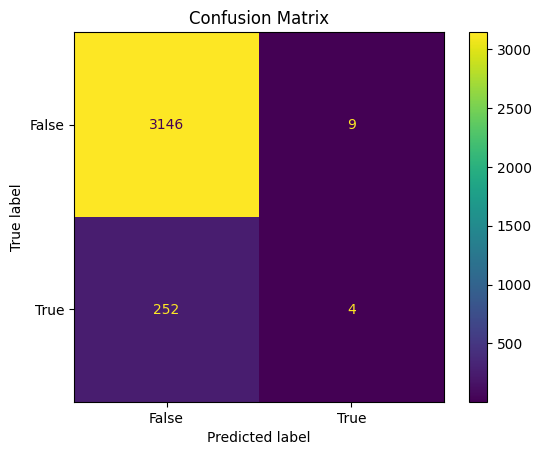

In [50]:
# visualize confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=[False, True]
)
cm_display.plot()
plt.title("Confusion Matrix")
plt.show()

In [51]:
# True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP = confusion_matrix[1, 1]
FP = confusion_matrix[0, 1]
TN = confusion_matrix[0, 0]
FN = confusion_matrix[1, 0]

# Calculate Recall
recall = TP / (TP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate F1 Score
f1_score = 2 * ((precision * recall) / (precision + recall))

# Print the results rounded to 2 decimal places
print("Recall:", round(recall, 2))
print("Precision:", round(precision, 2))
print("F1 Score:", round(f1_score, 2))

Recall: 0.02
Precision: 0.31
F1 Score: 0.03


In [52]:
final_model_data["FINAL DELINQUENT INDICATOR"].value_counts()

0    16229
1     1242
Name: FINAL DELINQUENT INDICATOR, dtype: int64

> The problem I see here is that there's a large number of false negative (252) and a small number of true positive (4). It means that there are 252 mortgages classified as safe that are actually not, and only 4 mortagegs that is correctly classified as not safe. The model is highly biased towards predicting negatives, being shown in the low precision, recall and F-1 score, which is due to an imbalanced dataset where negatives (safe mortage) far outnumber positives (unsafe mortage). Therefore, the model is not effective at identifying actual positive instances. In another word, the model has sigficant issue with correctly detecting mortgages that is not safe. 

### Exercise 14

To address the problem from Exercise 13, use `.predict_proba()` to set your own threshold for classification. Your stakeholder is mostly concerned with False Negatives (mortgages classified as safe that actually are not), so use a 8% probability threshold to get a good balance of a low False Negative rate with a reasonable amount of mortgages still being considered "viable."

What is the False Negative rate at an 8% classification threshold from the model above?

Store the result under the key `"ex14_false_negative_rate"`.

In [53]:
# Predict y labels with threshold = 0.08
y_pred_008 = (clf.predict_proba(X_test)[:, 1] >= 0.08).astype(bool)

# Generate confusion matrix
confusion_matrix_0_08 = metrics.confusion_matrix(y_test, y_pred_008)

confusion_matrix_0_08

array([[2387,  768],
       [ 123,  133]])

In [54]:
roc_auc_008 = roc_auc_score(y_test, y_pred_008)

roc_auc_008

0.6380540560618067

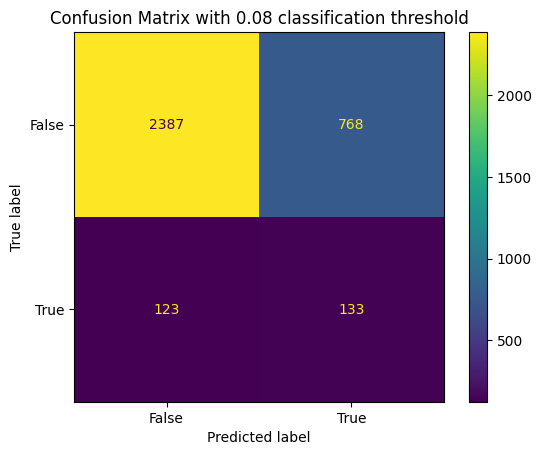

In [55]:
# visualize confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_0_08, display_labels=[False, True]
)
cm_display.plot()
plt.title("Confusion Matrix with 0.08 classification threshold")
plt.show()

In [56]:
# True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP_008 = confusion_matrix_0_08[1, 1]
FP_008 = confusion_matrix_0_08[0, 1]
TN_008 = confusion_matrix_0_08[0, 0]
FN_008 = confusion_matrix_0_08[1, 0]

# Calculate Recall for the 8% threshold
recall_008 = TP_008 / (TP_008 + FN_008)

# Calculate Precision for the 8% threshold
precision_008 = TP_008 / (TP_008 + FP_008)

# Calculate F1 Score for the 8% threshold
f1_score_008 = 2 * ((precision_008 * recall_008) / (precision_008 + recall_008))

# Calculate False Negative Rate (FNR) for the 8% threshold
fnr_008 = FN_008 / (FN_008 + TP_008)

# Calulate False Omission Rate (FOR) for the 8% threshold
for_008 = FN_008 / (FN_008 + TN_008)

# Print the results rounded to 2 decimal places
print("Recall:", round(recall_008, 2))
print("Precision:", round(precision_008, 2))
print("F1 Score:", round(f1_score_008, 2))
print("False Negative Rate:", round(fnr_008, 2))
print("False Omission Rate:", round(for_008, 2))

Recall: 0.52
Precision: 0.15
F1 Score: 0.23
False Negative Rate: 0.48
False Omission Rate: 0.05


In [57]:
ex14_false_omission_rate = for_008
results["ex14_false_omission_rate"] = ex14_false_omission_rate
print(
    f"The false omission rate at an 8% classification threshold is around {ex14_false_omission_rate:.2%}."
)

The false omission rate at an 8% classification threshold is around 4.90%.


### Exercise 15

Your stakeholder wants to by as many mortgages as it can while maintaining a delinquency rate of purchased mortgages below 5%. Based on your answer above, do you feel like your model can provide that level of performance?

In [58]:
print(f"The model's delinquency rate is around {ex14_false_omission_rate:.2%}.")

The model's delinquency rate is around 4.90%.


> We interpret the model's delinquency rate in the context of minimizing mortgages classified as safe that actually are not. Our model's False Omission Rate (FOR) is around 4.90%, which is calculated as the number of false negatives divided by the total number of predicted negatives. This rate measures the proportion of negative predictions that were incorrect. Therefore, it meets our stakeholder's expectation of maintaining a delinquency rate of purchased mortgages below 5%. I believe my model can provide the level of performance. 

## Now To The Future

The preceding analysis is precisely the type of analysis you would do if, in late 2006, you'd been asked to evaluate mortgage performance in the last two years for use going forward. So let's see how your model performs now!

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

### Exercise 16

Please load this data (again, from a URL to help the autograder) and clean it in the same manner as before. As a sanity check, how many observations do you have in the final dataset (after you've removed observations with missing values to allow you to generate predicted delinquency rates)? 

Store the final number of observations in `"ex16_num_obs"` and the share of those mortgages that are delinquent in `"ex16_share_delinquent"`


> Load Data 

In [59]:
orig_2007 = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2007/sample_orig_2007.txt",
    header=None,
    delimiter="|",
    encoding="latin1",
)

mortgage_info_records_2007 = [
    "CREDIT SCORE",
    "FIRST PAYMENT DATE",
    "FIRST TIME HOMEBUYER FLAG",
    "MATURITY DATE",
    "METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION",
    "MORTGAGE INSURANCE PERCENTAGE (MI %)",
    "NUMBER OF UNITS",
    "OCCUPANCY STATUS",
    "ORIGINAL COMBINED LOAN-TO-VALUE (CLTV)",
    "ORIGINAL DEBT-TO-INCOME (DTI) RATIO",
    "ORIGINAL UPB",
    "ORIGINAL LOAN-TO-VALUE (LTV)",
    "ORIGINAL INTEREST RATE",
    "CHANNEL",
    "PREPAYMENT PENALTY MORTGAGE (PPM) FLAG",
    "AMORTIZATION TYPE",
    "PROPERTY STATE",
    "PROPERTY TYPE",
    "POSTAL CODE",
    "LOAN SEQUENCE NUMBER",
    "LOAN PURPOSE",
    "ORIGINAL LOAN TERM",
    "NUMBER OF BORROWERS",
    "SELLER NAME",
    "SERVICER NAME",
    "SUPER CONFORMING FLAG",
    "PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER",
    "PROGRAM INDICATOR",
    "RELIEF REFINANCE INDICATOR",
    "PROPERTY VALUATION METHOD",
    "INTEREST ONLY INDICATOR (I/O INDICATOR)",
    "MI CANCELLATION INDICATOR",
]


orig_2007.columns = mortgage_info_records_2007
orig_2007.head()

,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT-TO-INCOME (DTI) RATIO,...,NUMBER OF BORROWERS,SELLER NAME,SERVICER NAME,SUPER CONFORMING FLAG,PRE-RELIEF REFINANCE LOAN SEQUENCE NUMBER,PROGRAM INDICATOR,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR
0,769,200702,N,203701,24220.0,0,1,P,90,38,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
1,598,200703,N,203702,NaN,0,1,P,90,45,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
2,777,200703,N,203702,20260.0,0,1,P,75,23,...,2,Other sellers,U.S. BANK N.A.,NaN,NaN,9,NaN,9,N,9
3,628,200703,N,203702,35644.0,0,1,P,65,38,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
4,651,200703,N,203702,NaN,0,1,P,75,38,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9


In [60]:
svcg_2007 = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/mortgages/2007/sample_svcg_2007orig_3years.txt",
    header=None,
    delimiter="|",
    encoding="latin1",
).iloc[
    :, 1:
]  # get rid of the first order column

monthly_mortgage_records_2007 = [
    "LOAN SEQUENCE NUMBER",
    "MONTHLY REPORTING PERIOD",
    "CURRENT ACTUAL UPB",
    "CURRENT LOAN DELINQUENCY STATUS",
    "LOAN AGE",
    "REMAINING MONTHS TO LEGAL MATURITY",
    "DEFECT SETTLEMENT DATE",
    "MODIFICATION FLAG",
    "ZERO BALANCE CODE",
    "ZERO BALANCE EFFECTIVE DATE",
    "CURRENT INTEREST RATE",
    "CURRENT NON-INTEREST BEARING UPB",
    "DUE DATE OF LAST PAID INSTALLMENT (DDLPI)",
    "MI RECOVERIES",
    "NET SALES PROCEEDS",
    "NON MI RECOVERIES",
    "TOTAL EXPENSES",
    "LEGAL COSTS",
    "MAINTENANCE AND PRESERVATION COSTS",
    "TAXES AND INSURANCE",
    "MISCELLANEOUS EXPENSES",
    "ACTUAL LOSS CALCULATION",
    "CUMULATIVE MODIFICATION COST",
    "STEP MODIFICATION FLAG",
    "PAYMENT DEFERRAL",
    "ESTIMATED LOAN TO VALUE (ELTV)",
    "ZERO BALANCE REMOVAL UPB",
    "DELINQUENT ACCRUED INTEREST",
    "DELINQUENCY DUE TO DISASTER",
    "BORROWER ASSISTANCE STATUS CODE",
    "CURRENT MONTH MODIFICATION COST",
    "INTEREST BEARING UPB",
]

svcg_2007.columns = monthly_mortgage_records_2007
svcg_2007.head()

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,DEFECT SETTLEMENT DATE,MODIFICATION FLAG,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,...,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,PAYMENT DEFERRAL,ESTIMATED LOAN TO VALUE (ELTV),ZERO BALANCE REMOVAL UPB,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB
0,F07Q10000023,200702,195000.0,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0
1,F07Q10000023,200703,195000.0,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0
2,F07Q10000023,200704,195000.0,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.0
3,F07Q10000023,200705,194000.0,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194000.0
4,F07Q10000023,200706,194000.0,0,5,355,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194000.0


In [61]:
svcg_2007

,LOAN SEQUENCE NUMBER,MONTHLY REPORTING PERIOD,CURRENT ACTUAL UPB,CURRENT LOAN DELINQUENCY STATUS,LOAN AGE,REMAINING MONTHS TO LEGAL MATURITY,DEFECT SETTLEMENT DATE,MODIFICATION FLAG,ZERO BALANCE CODE,ZERO BALANCE EFFECTIVE DATE,...,CUMULATIVE MODIFICATION COST,STEP MODIFICATION FLAG,PAYMENT DEFERRAL,ESTIMATED LOAN TO VALUE (ELTV),ZERO BALANCE REMOVAL UPB,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB
0,F07Q10000023,200702,195000.00,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.00
1,F07Q10000023,200703,195000.00,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.00
2,F07Q10000023,200704,195000.00,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,195000.00
3,F07Q10000023,200705,194000.00,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194000.00
4,F07Q10000023,200706,194000.00,0,5,355,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1277766,F07Q40428907,200911,84809.94,0,23,217,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84809.94
1277767,F07Q40428907,200912,84569.33,0,24,216,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84569.33
1277768,F07Q40428933,200910,174022.85,0,17,343,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174022.85
1277769,F07Q40428933,200911,173655.00,0,18,342,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173655.00


> Merge Data

In [62]:
print(
    "I want to perform an inner join on the two dataframes orig_2007 and svcg_2007 on the column 'LOAN SEQUENCE NUMBER'"
)
# Attempt the merge with validation
try:
    # The merge is expected to be one-to-many based on the assumptions
    merged_inner_2007 = pd.merge(
        orig_2007, svcg_2007, how="inner", on="LOAN SEQUENCE NUMBER", validate="1:m"
    )
    print("The type of merge is one to many.")
except Exception as e:
    print("The type of merge is not one to many:", e)
    pass

I want to perform an inner join on the two dataframes orig_2007 and svcg_2007 on the column 'LOAN SEQUENCE NUMBER'
The type of merge is one to many.


In [63]:
print(f"The shape of the merged data is : {merged_inner_2007.shape}.")

The shape of the merged data is : (1277771, 63).


> Filter by Loan Purpose

In [64]:
merged_property_2007 = merged_inner_2007[merged_inner_2007["LOAN PURPOSE"] == "P"]

> Filter by first payments due in the quarter of origination or the first quarter after origination

In [65]:
# check what unique year in this dataframe is loan being originally assigned
merged_property_2007["LOAN YEAR"] = (
    merged_property_2007["LOAN SEQUENCE NUMBER"].str[1:3].astype(int)
) + 2000
merged_property_2007["LOAN YEAR"].unique()

array([2007])

In [66]:
# check what unqiue year in the dataframe is loan first being paid
merged_property_2007["FIRST PAYMENT YEAR"] = (
    merged_property_2007["FIRST PAYMENT DATE"].astype(str).str[0:4].astype(int)
)
merged_property_2007["FIRST PAYMENT YEAR"].unique()

array([2007, 2008, 2009])

In [67]:
# check what unqiue quarter in the dataframe is loan being originally assigned
merged_property_2007["LOAN QUARTER"] = (
    merged_property_2007["LOAN SEQUENCE NUMBER"].str[4].astype(int)
)  # format is PYYQnXXXXXXX
merged_property_2007["LOAN QUARTER"].unique()

array([1, 2, 3, 4])

In [68]:
# Calculate quarter of loan first being paid
merged_property_2007["FIRST PAYMENT MONTH"] = (
    merged_property_2007["FIRST PAYMENT DATE"].astype(str).str[-2:].astype(int)
)  # YYYYMM


# Convert month to quarter
def month_to_quarter(month):
    if month >= 1 and month <= 3:
        quarter = "1"
    elif month >= 4 and month <= 6:
        quarter = "2"
    elif month >= 7 and month <= 9:
        quarter = "3"
    elif month >= 10 and month <= 12:
        quarter = "4"
    else:
        quarter = "Unknown"
    return quarter


# Apply the function to each row in the DataFrame
merged_property_2007["FIRST PAYMENT QUARTER"] = (
    merged_property_2007["FIRST PAYMENT MONTH"].apply(month_to_quarter).astype(int)
)

# check unique quater in first payment quarter
merged_property_2007["FIRST PAYMENT QUARTER"].unique()

array([1, 2, 3, 4])

In [69]:
# check the newly created columns
merged_property_2007[
    [
        "FIRST PAYMENT DATE",
        "LOAN SEQUENCE NUMBER",
        "FIRST PAYMENT YEAR",
        "FIRST PAYMENT MONTH",
        "FIRST PAYMENT QUARTER",
        "LOAN YEAR",
        "LOAN QUARTER",
    ]
].head()

,FIRST PAYMENT DATE,LOAN SEQUENCE NUMBER,FIRST PAYMENT YEAR,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER,LOAN YEAR,LOAN QUARTER
0,200702,F07Q10000023,2007,2,1,2007,1
1,200702,F07Q10000023,2007,2,1,2007,1
2,200702,F07Q10000023,2007,2,1,2007,1
3,200702,F07Q10000023,2007,2,1,2007,1
4,200702,F07Q10000023,2007,2,1,2007,1


In [70]:
# if loan year=first payment year, keep all the columns that first payment quarter = loan quarter
# or first payment quarter = loan quarter+1
# if first payment year = loan year+1 and loan quarter = 4
# keep all the column that first payment quarter= 1
filtered_merged_property_2007 = merged_property_2007[
    (
        (
            merged_property_2007["LOAN YEAR"]
            == merged_property_2007["FIRST PAYMENT YEAR"]
        )
        & (
            (
                merged_property_2007["FIRST PAYMENT QUARTER"]
                == merged_property_2007["LOAN QUARTER"]
            )
            | (
                merged_property_2007["FIRST PAYMENT QUARTER"]
                == merged_property_2007["LOAN QUARTER"] + 1
            )
        )
    )
    | (
        (
            merged_property_2007["FIRST PAYMENT YEAR"]
            == merged_property_2007["LOAN YEAR"] + 1
        )
        & (merged_property_2007["LOAN QUARTER"] == 4)
        & (merged_property_2007["FIRST PAYMENT QUARTER"] == 1)
    )
]

# Display the filtered DataFrame
filtered_merged_property_2007.head()

,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,ORIGINAL COMBINED LOAN-TO-VALUE (CLTV),ORIGINAL DEBT-TO-INCOME (DTI) RATIO,...,DELINQUENT ACCRUED INTEREST,DELINQUENCY DUE TO DISASTER,BORROWER ASSISTANCE STATUS CODE,CURRENT MONTH MODIFICATION COST,INTEREST BEARING UPB,LOAN YEAR,FIRST PAYMENT YEAR,LOAN QUARTER,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER
0,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,195000.0,2007,2007,1,2,1
1,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,195000.0,2007,2007,1,2,1
2,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,195000.0,2007,2007,1,2,1
3,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,194000.0,2007,2007,1,2,1
4,769,200702,N,203701,24220.0,0,1,P,90,38,...,NaN,NaN,NaN,NaN,194000.0,2007,2007,1,2,1


In [71]:
number_mortgages = len(filtered_merged_property_2007["LOAN SEQUENCE NUMBER"].unique())
print(f"The number of unique mortgages is : {number_mortgages}")

The number of unique mortgages is : 22566


> Filter by first 24 due dates

In [72]:
filtered_merged_property_2007["MONTHLY REPORTING PERIOD"] = pd.to_datetime(
    filtered_merged_property_2007["MONTHLY REPORTING PERIOD"], format="%Y%m"
)
filtered_merged_property_2007["FIRST PAYMENT DATE"] = pd.to_datetime(
    filtered_merged_property_2007["FIRST PAYMENT DATE"], format="%Y%m"
)
# Calculate the difference in months between the first payment date and each monthly reporting period
filtered_merged_property_2007["Months_Since_First_Payment"] = (
    filtered_merged_property_2007["MONTHLY REPORTING PERIOD"]
    - filtered_merged_property_2007["FIRST PAYMENT DATE"]
).dt.days // 30
filtered_merged_property_2007["Months_Since_First_Payment"]
# Subset the data to the first 24 (possible) payment due dates
filtered_merged_property_24_2007 = filtered_merged_property_2007[
    (filtered_merged_property_2007["Months_Since_First_Payment"] >= 0)
    & (filtered_merged_property_2007["Months_Since_First_Payment"] <= 23)
]
num_obs = filtered_merged_property_24_2007.shape[0]

print(f"the number of remaining observations is {num_obs}.")

the number of remaining observations is 481871.


> Create indicator variable

In [73]:
# convert every unique value in CURRENT LOAN DELINQUENCY STATUS to string
filtered_merged_property_24_2007["CURRENT LOAN DELINQUENCY STATUS"] = (
    filtered_merged_property_24_2007["CURRENT LOAN DELINQUENCY STATUS"].astype(str)
)

In [74]:
# Create a temporary indicator for delinquency status for each row, ignoring NaN values
filtered_merged_property_24_2007["TEMP DELINQUENT INDICATOR"] = (
    filtered_merged_property_24_2007["CURRENT LOAN DELINQUENCY STATUS"].apply(
        lambda x: 0 if x == "0" else 1
    )
)

# Group by LOAN SEQUENCE NUMBER and aggregate to find if there was any delinquency
delinquency_indicator_2007 = (
    filtered_merged_property_24_2007.groupby("LOAN SEQUENCE NUMBER")[
        "TEMP DELINQUENT INDICATOR"
    ]
    .max()
    .reset_index()
)

# Rename the column in the delinquency_indicator DataFrame
delinquency_indicator_2007 = delinquency_indicator_2007.rename(
    columns={"TEMP DELINQUENT INDICATOR": "FINAL DELINQUENT INDICATOR"}
)

delinquency_indicator_2007.head()

,LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,F07Q10000023,0
1,F07Q10000059,0
2,F07Q10000092,0
3,F07Q10000141,0
4,F07Q10000653,0


In [75]:
# Extract unique loan sequence number from each dataframe
unique_df1 = set(filtered_merged_property_24_2007["LOAN SEQUENCE NUMBER"].unique())
unique_df2 = set(delinquency_indicator_2007["LOAN SEQUENCE NUMBER"].unique())

# Check if the unique loan sequence numbers in df1 are also in df2
number_in_df1_not_in_df2 = unique_df1 - unique_df2

# Check if the unique loan sequence numbers in df2 are also in df1
number_in_df2_not_in_df1 = unique_df2 - unique_df1

print(
    "LOAN SEQUENCE NUMBER in filtered_merged_property_24_2007 but not in delinquency_indicator_2007:",
    number_in_df1_not_in_df2,
)
print(
    "LOAN SEQUENCE NUMBER in delinquency_indicator_2007 but not in filtered_merged_property_24_2007:",
    number_in_df2_not_in_df1,
)

# To check if they are the same:
if not number_in_df1_not_in_df2 and not number_in_df2_not_in_df1:
    print(
        "Both dataframes have the same unique values in the LOAN SEQUENCE NUMBER column."
    )
else:
    print(
        "The dataframes have different unique values in the LOAN SEQUENCE NUMBER column."
    )

LOAN SEQUENCE NUMBER in filtered_merged_property_24_2007 but not in delinquency_indicator_2007: set()
LOAN SEQUENCE NUMBER in delinquency_indicator_2007 but not in filtered_merged_property_24_2007: set()
Both dataframes have the same unique values in the LOAN SEQUENCE NUMBER column.


In [76]:
print(
    "I want to perform an inner join on the two dataframes delinquency_indicator_2007 and filtered_merged_property_24_2007 on the column 'LOAN SEQUENCE NUMBER'"
)
# Attempt the merge with validation
try:
    # The merge is expected to be one-to-many based on the assumptions
    merged_2007 = pd.merge(
        delinquency_indicator_2007,
        filtered_merged_property_24_2007,
        how="inner",
        on="LOAN SEQUENCE NUMBER",
        validate="1:m",
    )
    print("The type of merge is one to many.")
except Exception as e:
    print("The type of merge is not one to many:", e)
    pass

I want to perform an inner join on the two dataframes delinquency_indicator_2007 and filtered_merged_property_24_2007 on the column 'LOAN SEQUENCE NUMBER'
The type of merge is one to many.


In [77]:
shape_merged_2007 = merged_2007.shape
print(f"The shape of the merged data is {shape_merged_2007}.")

The shape of the merged data is (481871, 71).


> Drop all servicing variables reported on a monthly basis 

In [78]:
# check the unique number of loan sequence number in the merged inner dataframe
merged_2007["LOAN SEQUENCE NUMBER"].nunique()
print(
    f"The unique number of loan sequence number in the merged inner dataframe is {merged_inner['LOAN SEQUENCE NUMBER'].nunique()}."
)

The unique number of loan sequence number in the merged inner dataframe is 17471.


In [79]:
# all servicing variables reported on a monthly basis
new_monthly_mortgage_records = [
    "MONTHLY REPORTING PERIOD",
    "CURRENT ACTUAL UPB",
    "CURRENT LOAN DELINQUENCY STATUS",
    "LOAN AGE",
    "REMAINING MONTHS TO LEGAL MATURITY",
    "DEFECT SETTLEMENT DATE",
    "MODIFICATION FLAG",
    "ZERO BALANCE CODE",
    "ZERO BALANCE EFFECTIVE DATE",
    "CURRENT INTEREST RATE",
    "CURRENT NON-INTEREST BEARING UPB",
    "DUE DATE OF LAST PAID INSTALLMENT (DDLPI)",
    "MI RECOVERIES",
    "NET SALES PROCEEDS",
    "NON MI RECOVERIES",
    "TOTAL EXPENSES",
    "LEGAL COSTS",
    "MAINTENANCE AND PRESERVATION COSTS",
    "TAXES AND INSURANCE",
    "MISCELLANEOUS EXPENSES",
    "ACTUAL LOSS CALCULATION",
    "CUMULATIVE MODIFICATION COST",
    "STEP MODIFICATION FLAG",
    "PAYMENT DEFERRAL",
    "ESTIMATED LOAN TO VALUE (ELTV)",
    "ZERO BALANCE REMOVAL UPB",
    "DELINQUENT ACCRUED INTEREST",
    "DELINQUENCY DUE TO DISASTER",
    "BORROWER ASSISTANCE STATUS CODE",
    "CURRENT MONTH MODIFICATION COST",
    "INTEREST BEARING UPB",
]

# other variables that can be dropped
created_variables = ["TEMP DELINQUENT INDICATOR"]

columns_to_drop = new_monthly_mortgage_records + created_variables

In [80]:
# Drop the specified columns from merged_inner
merged_2007_cleaned = merged_2007.drop(columns=columns_to_drop, errors="ignore")

merged_2007_cleaned.head()  # Display the first few rows of the cleaned DataFrame

,LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR,CREDIT SCORE,FIRST PAYMENT DATE,FIRST TIME HOMEBUYER FLAG,MATURITY DATE,METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION,MORTGAGE INSURANCE PERCENTAGE (MI %),NUMBER OF UNITS,OCCUPANCY STATUS,...,RELIEF REFINANCE INDICATOR,PROPERTY VALUATION METHOD,INTEREST ONLY INDICATOR (I/O INDICATOR),MI CANCELLATION INDICATOR,LOAN YEAR,FIRST PAYMENT YEAR,LOAN QUARTER,FIRST PAYMENT MONTH,FIRST PAYMENT QUARTER,Months_Since_First_Payment
0,F07Q10000023,0,769,2007-02-01,N,203701,24220.0,0,1,P,...,NaN,9,N,9,2007,2007,1,2,1,0
1,F07Q10000023,0,769,2007-02-01,N,203701,24220.0,0,1,P,...,NaN,9,N,9,2007,2007,1,2,1,0
2,F07Q10000023,0,769,2007-02-01,N,203701,24220.0,0,1,P,...,NaN,9,N,9,2007,2007,1,2,1,1
3,F07Q10000023,0,769,2007-02-01,N,203701,24220.0,0,1,P,...,NaN,9,N,9,2007,2007,1,2,1,2
4,F07Q10000023,0,769,2007-02-01,N,203701,24220.0,0,1,P,...,NaN,9,N,9,2007,2007,1,2,1,4


In [81]:
# check for duplicated columns
merged_2007_cleaned.duplicated().sum()
merged_2007_cleaned.shape[0]
print(
    f"There are in total {merged_2007_cleaned.duplicated().sum()} duplicated columns after dropping the servicing variables reported on a monthly basis out of the total {merged_2007_cleaned.shape[0]} columns."
)

There are in total 1679 duplicated columns after dropping the servicing variables reported on a monthly basis out of the total 481871 columns.


In [82]:
# count the unique LOAN SEQUENCE NUMBER
unique = merged_2007_cleaned["LOAN SEQUENCE NUMBER"].nunique()
print(f"The number of unique loans in the dataframe is {unique}.")

The number of unique loans in the dataframe is 22542.


In [83]:
# Drop duplicates based on 'LOAN SEQUENCE NUMBER', keeping the first occurrence
merged_unique = merged_2007_cleaned.drop_duplicates(subset=["LOAN SEQUENCE NUMBER"])

# Display the shape of the DataFrame to verify duplicates are dropped
num_mortgages_unique = merged_unique.shape[0]

print(
    f"The shape of the dataframe after the duplicates is dropped is {num_mortgages_unique}."
)

The shape of the dataframe after the duplicates is dropped is 22542.


> Modeling Delinquency Risk

In [84]:
new_variables = [
    "CREDIT SCORE",
    "FIRST TIME HOMEBUYER FLAG",
    "NUMBER OF UNITS",
    "MORTGAGE INSURANCE PERCENTAGE (MI %)",
    "OCCUPANCY STATUS",
    "ORIGINAL DEBT-TO-INCOME (DTI) RATIO",
    "ORIGINAL UPB",
    "ORIGINAL LOAN-TO-VALUE (LTV)",
    "ORIGINAL INTEREST RATE",
    "CHANNEL",
    "PREPAYMENT PENALTY MORTGAGE (PPM) FLAG",
    "AMORTIZATION TYPE",
    "PROPERTY STATE",
    "PROPERTY TYPE",
    "ORIGINAL LOAN TERM",
    "NUMBER OF BORROWERS",
    "INTEREST ONLY INDICATOR (I/O INDICATOR)",
    "LOAN SEQUENCE NUMBER",
    "FINAL DELINQUENT INDICATOR",
]

In [85]:
# Filter the DataFrame to include only the columns listed in new_variables
merged_unique_filtered = merged_unique[new_variables]

# get the head of the filtered dataframe
merged_unique_filtered.head()

,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,NUMBER OF UNITS,MORTGAGE INSURANCE PERCENTAGE (MI %),OCCUPANCY STATUS,ORIGINAL DEBT-TO-INCOME (DTI) RATIO,ORIGINAL UPB,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL INTEREST RATE,CHANNEL,PREPAYMENT PENALTY MORTGAGE (PPM) FLAG,AMORTIZATION TYPE,PROPERTY STATE,PROPERTY TYPE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,INTEREST ONLY INDICATOR (I/O INDICATOR),LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,769,N,1,0,P,38,195000,80,6.125,R,N,FRM,ND,SF,360,2,N,F07Q10000023,0
24,598,N,1,0,P,45,136000,80,6.000,R,N,FRM,ND,SF,360,2,N,F07Q10000059,0
48,777,N,1,0,P,23,137000,75,5.750,R,N,FRM,MN,SF,360,2,N,F07Q10000092,0
72,628,N,1,0,P,38,285000,65,6.250,R,N,FRM,NY,SF,360,2,N,F07Q10000141,0
95,676,N,1,16,P,32,149000,95,6.500,R,N,FRM,WI,SF,360,1,N,F07Q10000653,0


In [86]:
# perform some precleaning checks
for column in merged_unique_filtered.columns:
    # Variable name
    print(f"Variable Name: {column}")

    # Count of missing values
    missing_values_count = merged_unique_filtered[column].isna().sum()
    print(f"Count of Missing Values: {missing_values_count}")

    # Data type of the variable
    data_type = merged_unique_filtered[column].dtype
    print(f"Data Type: {data_type}\n")

Variable Name: CREDIT SCORE
Count of Missing Values: 0
Data Type: int64

Variable Name: FIRST TIME HOMEBUYER FLAG
Count of Missing Values: 0
Data Type: object

Variable Name: NUMBER OF UNITS
Count of Missing Values: 0
Data Type: int64

Variable Name: MORTGAGE INSURANCE PERCENTAGE (MI %)
Count of Missing Values: 0
Data Type: int64

Variable Name: OCCUPANCY STATUS
Count of Missing Values: 0
Data Type: object

Variable Name: ORIGINAL DEBT-TO-INCOME (DTI) RATIO
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL UPB
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL LOAN-TO-VALUE (LTV)
Count of Missing Values: 0
Data Type: int64

Variable Name: ORIGINAL INTEREST RATE
Count of Missing Values: 0
Data Type: float64

Variable Name: CHANNEL
Count of Missing Values: 0
Data Type: object

Variable Name: PREPAYMENT PENALTY MORTGAGE (PPM) FLAG
Count of Missing Values: 0
Data Type: object

Variable Name: AMORTIZATION TYPE
Count of Missing Values: 0
Data Type: object

In [87]:
merged_unique_filtered["CREDIT SCORE"] = merged_unique_filtered["CREDIT SCORE"].replace(
    9999, np.nan
)
merged_unique_filtered["FIRST TIME HOMEBUYER FLAG"] = merged_unique_filtered[
    "FIRST TIME HOMEBUYER FLAG"
].replace("9", np.nan)
merged_unique_filtered["MORTGAGE INSURANCE PERCENTAGE (MI %)"] = merged_unique_filtered[
    "MORTGAGE INSURANCE PERCENTAGE (MI %)"
].replace(999, np.nan)
merged_unique_filtered["NUMBER OF UNITS"] = merged_unique_filtered[
    "NUMBER OF UNITS"
].replace(99, np.nan)
merged_unique_filtered["OCCUPANCY STATUS"] = merged_unique_filtered[
    "OCCUPANCY STATUS"
].replace("9", np.nan)
merged_unique_filtered["ORIGINAL DEBT-TO-INCOME (DTI) RATIO"] = merged_unique_filtered[
    "ORIGINAL DEBT-TO-INCOME (DTI) RATIO"
].replace(999, np.nan)
merged_unique_filtered["ORIGINAL LOAN-TO-VALUE (LTV)"] = merged_unique_filtered[
    "ORIGINAL LOAN-TO-VALUE (LTV)"
].replace(999, np.nan)
merged_unique_filtered["CHANNEL"] = merged_unique_filtered["CHANNEL"].replace(
    "9", np.nan
)
merged_unique_filtered["PROPERTY TYPE"] = merged_unique_filtered[
    "PROPERTY TYPE"
].replace("99", np.nan)
merged_unique_filtered["NUMBER OF BORROWERS"] = merged_unique_filtered[
    "NUMBER OF BORROWERS"
].replace(99, np.nan)

In [88]:
# drop na values
cleaned = merged_unique_filtered.dropna()

In [89]:
cleaned.head()

,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,NUMBER OF UNITS,MORTGAGE INSURANCE PERCENTAGE (MI %),OCCUPANCY STATUS,ORIGINAL DEBT-TO-INCOME (DTI) RATIO,ORIGINAL UPB,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL INTEREST RATE,CHANNEL,PREPAYMENT PENALTY MORTGAGE (PPM) FLAG,AMORTIZATION TYPE,PROPERTY STATE,PROPERTY TYPE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,INTEREST ONLY INDICATOR (I/O INDICATOR),LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,769.0,N,1,0,P,38.0,195000,80,6.125,R,N,FRM,ND,SF,360,2.0,N,F07Q10000023,0
24,598.0,N,1,0,P,45.0,136000,80,6.000,R,N,FRM,ND,SF,360,2.0,N,F07Q10000059,0
48,777.0,N,1,0,P,23.0,137000,75,5.750,R,N,FRM,MN,SF,360,2.0,N,F07Q10000092,0
72,628.0,N,1,0,P,38.0,285000,65,6.250,R,N,FRM,NY,SF,360,2.0,N,F07Q10000141,0
95,676.0,N,1,16,P,32.0,149000,95,6.500,R,N,FRM,WI,SF,360,1.0,N,F07Q10000653,0


In [90]:
ex16_num_obs = cleaned.shape[0]
print(f"The final number of observations is {ex16_num_obs}.")

The final number of observations is 21972.


In [91]:
ex16_share_delinquent = cleaned["FINAL DELINQUENT INDICATOR"].mean()
print(
    f"The share of those mortgages that are delinquent is {ex16_share_delinquent:.2%}."
)

The share of those mortgages that are delinquent is 10.96%.


In [92]:
results["ex16_num_obs"] = ex16_num_obs
results["ex16_share_delinquent"] = ex16_share_delinquent

### Exercise 17




Had your stakeholder purchased mortgages using your model, what would the resulting False Negative rate have been? (e.g., compare the predicted values for mortgages using the model trained above with realized outcomes). Store your result under the key `"ex17_false_negative_rate"`


In [93]:
# sort the merged_inner_cleaned_unique_filtered according to loan sequence number
final = cleaned.sort_values(by="LOAN SEQUENCE NUMBER")

final.head()

,CREDIT SCORE,FIRST TIME HOMEBUYER FLAG,NUMBER OF UNITS,MORTGAGE INSURANCE PERCENTAGE (MI %),OCCUPANCY STATUS,ORIGINAL DEBT-TO-INCOME (DTI) RATIO,ORIGINAL UPB,ORIGINAL LOAN-TO-VALUE (LTV),ORIGINAL INTEREST RATE,CHANNEL,PREPAYMENT PENALTY MORTGAGE (PPM) FLAG,AMORTIZATION TYPE,PROPERTY STATE,PROPERTY TYPE,ORIGINAL LOAN TERM,NUMBER OF BORROWERS,INTEREST ONLY INDICATOR (I/O INDICATOR),LOAN SEQUENCE NUMBER,FINAL DELINQUENT INDICATOR
0,769.0,N,1,0,P,38.0,195000,80,6.125,R,N,FRM,ND,SF,360,2.0,N,F07Q10000023,0
24,598.0,N,1,0,P,45.0,136000,80,6.000,R,N,FRM,ND,SF,360,2.0,N,F07Q10000059,0
48,777.0,N,1,0,P,23.0,137000,75,5.750,R,N,FRM,MN,SF,360,2.0,N,F07Q10000092,0
72,628.0,N,1,0,P,38.0,285000,65,6.250,R,N,FRM,NY,SF,360,2.0,N,F07Q10000141,0
95,676.0,N,1,16,P,32.0,149000,95,6.500,R,N,FRM,WI,SF,360,1.0,N,F07Q10000653,0


In [94]:
# use dmatrices to one hot encode categorical variables in the dataframe
Y_2, X_2 = dmatrices(
    'Q("FINAL DELINQUENT INDICATOR") ~ C(Q("FIRST TIME HOMEBUYER FLAG")) + '
    'C(Q("NUMBER OF UNITS")) + C(Q("OCCUPANCY STATUS")) + C(Q("CHANNEL")) + '
    'C(Q("PREPAYMENT PENALTY MORTGAGE (PPM) FLAG")) + C(Q("AMORTIZATION TYPE")) + '
    'C(Q("PROPERTY STATE")) + C(Q("PROPERTY TYPE")) + C(Q("NUMBER OF BORROWERS")) + '
    'C(Q("INTEREST ONLY INDICATOR (I/O INDICATOR)")) + Q("CREDIT SCORE") + '
    'Q("MORTGAGE INSURANCE PERCENTAGE (MI %)") + Q("ORIGINAL DEBT-TO-INCOME (DTI) RATIO") + '
    'Q("ORIGINAL UPB") + Q("ORIGINAL LOAN-TO-VALUE (LTV)") + Q("ORIGINAL INTEREST RATE") + '
    'Q("ORIGINAL LOAN TERM")',
    final,
    return_type="dataframe",
)

In [95]:
# Check is X_2 columns is the same as X train columns
X_2.columns == X_train.columns

array([ True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [96]:
# set X_2 columns the same as X train columns
X_2.columns = X_train.columns

In [97]:
observations = Y_2.shape[0]
print(f"The number of observations in the final dataset is {observations}.")

The number of observations in the final dataset is 21972.


In [98]:
# Predict y labels with threshold = 0.08
y_pred_008 = (clf.predict_proba(X_2)[:, 1] >= 0.08).astype(bool)

# Generate confusion matrix
confusion_matrix_0_08 = metrics.confusion_matrix(Y_2, y_pred_008)

confusion_matrix_0_08

array([[14487,  5076],
       [  847,  1562]])

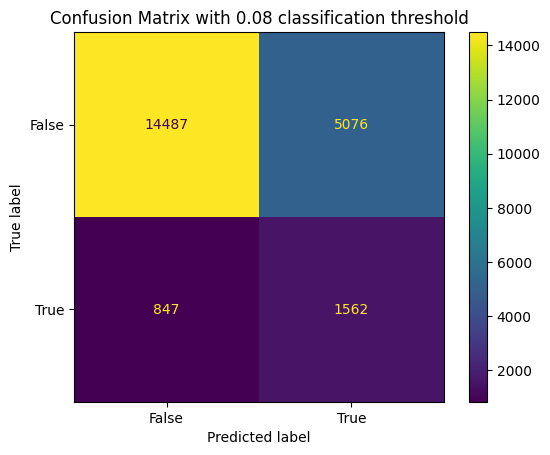

In [99]:
# visualize confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix_0_08, display_labels=[False, True]
)
cm_display.plot()
plt.title("Confusion Matrix with 0.08 classification threshold")
plt.show()

In [100]:
# True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN)
TP_008 = confusion_matrix_0_08[1, 1]
FP_008 = confusion_matrix_0_08[0, 1]
TN_008 = confusion_matrix_0_08[0, 0]
FN_008 = confusion_matrix_0_08[1, 0]

# Calculate Recall for the 8% threshold
recall_008 = TP_008 / (TP_008 + FN_008)

# Calculate Precision for the 8% threshold
precision_008 = TP_008 / (TP_008 + FP_008)

# Calculate F1 Score for the 8% threshold
f1_score_008 = 2 * ((precision_008 * recall_008) / (precision_008 + recall_008))

# Calculate False Negative Rate (FNR) for the 8% threshold
fnr_008 = FN_008 / (FN_008 + TP_008)

# Calulate False Omission Rate (FOR) for the 8% threshold
for_008 = FN_008 / (FN_008 + TN_008)

# Print the results rounded to 2 decimal places
print("Recall:", round(recall_008, 2))
print("Precision:", round(precision_008, 2))
print("F1 Score:", round(f1_score_008, 2))
print("False Negative Rate:", round(fnr_008, 2))
print("False Omission Rate:", round(for_008, 2))

Recall: 0.65
Precision: 0.24
F1 Score: 0.35
False Negative Rate: 0.35
False Omission Rate: 0.06


In [101]:
ex17_false_omission_rate = for_008
results["ex17_false_omission_rate"] = ex17_false_omission_rate
print(
    f"The false omission rate at an 8% classification threshold is around {ex17_false_omission_rate:.2%}."
)

The false omission rate at an 8% classification threshold is around 5.52%.


In [102]:
print(f"The model's delinquency rate is around {ex17_false_omission_rate:.2%}.")

The model's delinquency rate is around 5.52%.


### Exercise 18

How did the retrospective performance of your model compare to its actual performance moving forward? Why? Did you stay below the 5% target for False Negatives set by the stakeholder?

> Had my stakeholder purchased mortgages using my model, the resulting false omission rate at an 8% classification threshold is around 5.52%, which reflects the error rate within the group of mortgages classified as not delinquent. In this context, it means that the model missed 5.52% of delinquent mortgages it should have identified, assuming an 8% threshold for classifying a mortgage as high-risk. I did not stay below the 5% target for False Omission Rate set by the stakeholder.

In [103]:
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex4_num_mortgages",
    "ex5_num_obs",
    "ex7_num_mortgages",
    "ex7_share_delinquent",
    "ex10_num_obs",
    "ex12_roc_auc",
    "ex14_false_omission_rate",
    "ex16_num_obs",
    "ex16_share_delinquent",
    "ex17_false_omission_rate",
}